In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

%whos



Variable                 Type             Data/Info
---------------------------------------------------
BaseEstimator            type             <class 'sklearn.base.BaseEstimator'>
BayesianOptimization     type             <class 'bayes_opt.bayesia<...>on.BayesianOptimization'>
BayesianRidge            ABCMeta          <class 'sklearn.linear_mo<...>el._bayes.BayesianRidge'>
ElasticNet               ABCMeta          <class 'sklearn.linear_mo<...>nate_descent.ElasticNet'>
FeatureUnion             ABCMeta          <class 'sklearn.pipeline.FeatureUnion'>
GridSearchCV             ABCMeta          <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
InteractiveShell         MetaHasTraits    <class 'IPython.core.inte<...>eshell.InteractiveShell'>
Lasso                    ABCMeta          <class 'sklearn.linear_mo<...>oordinate_descent.Lasso'>
LassoLarsIC              ABCMeta          <class 'sklearn.linear_mo<...>least_angle.LassoLarsIC'>
OneHotEncoder            type             <class 

In [2]:
X = pd.read_csv("data/train.csv")
X_test = pd.read_csv("data/test.csv")
X.drop(['GarageYrBlt'], axis=1, inplace=True)
X.drop(['Utilities'], axis=1, inplace=True)
X_test.drop(['GarageYrBlt'], axis=1, inplace=True)
X_test.drop(['Utilities'], axis=1, inplace=True)

<AxesSubplot:>

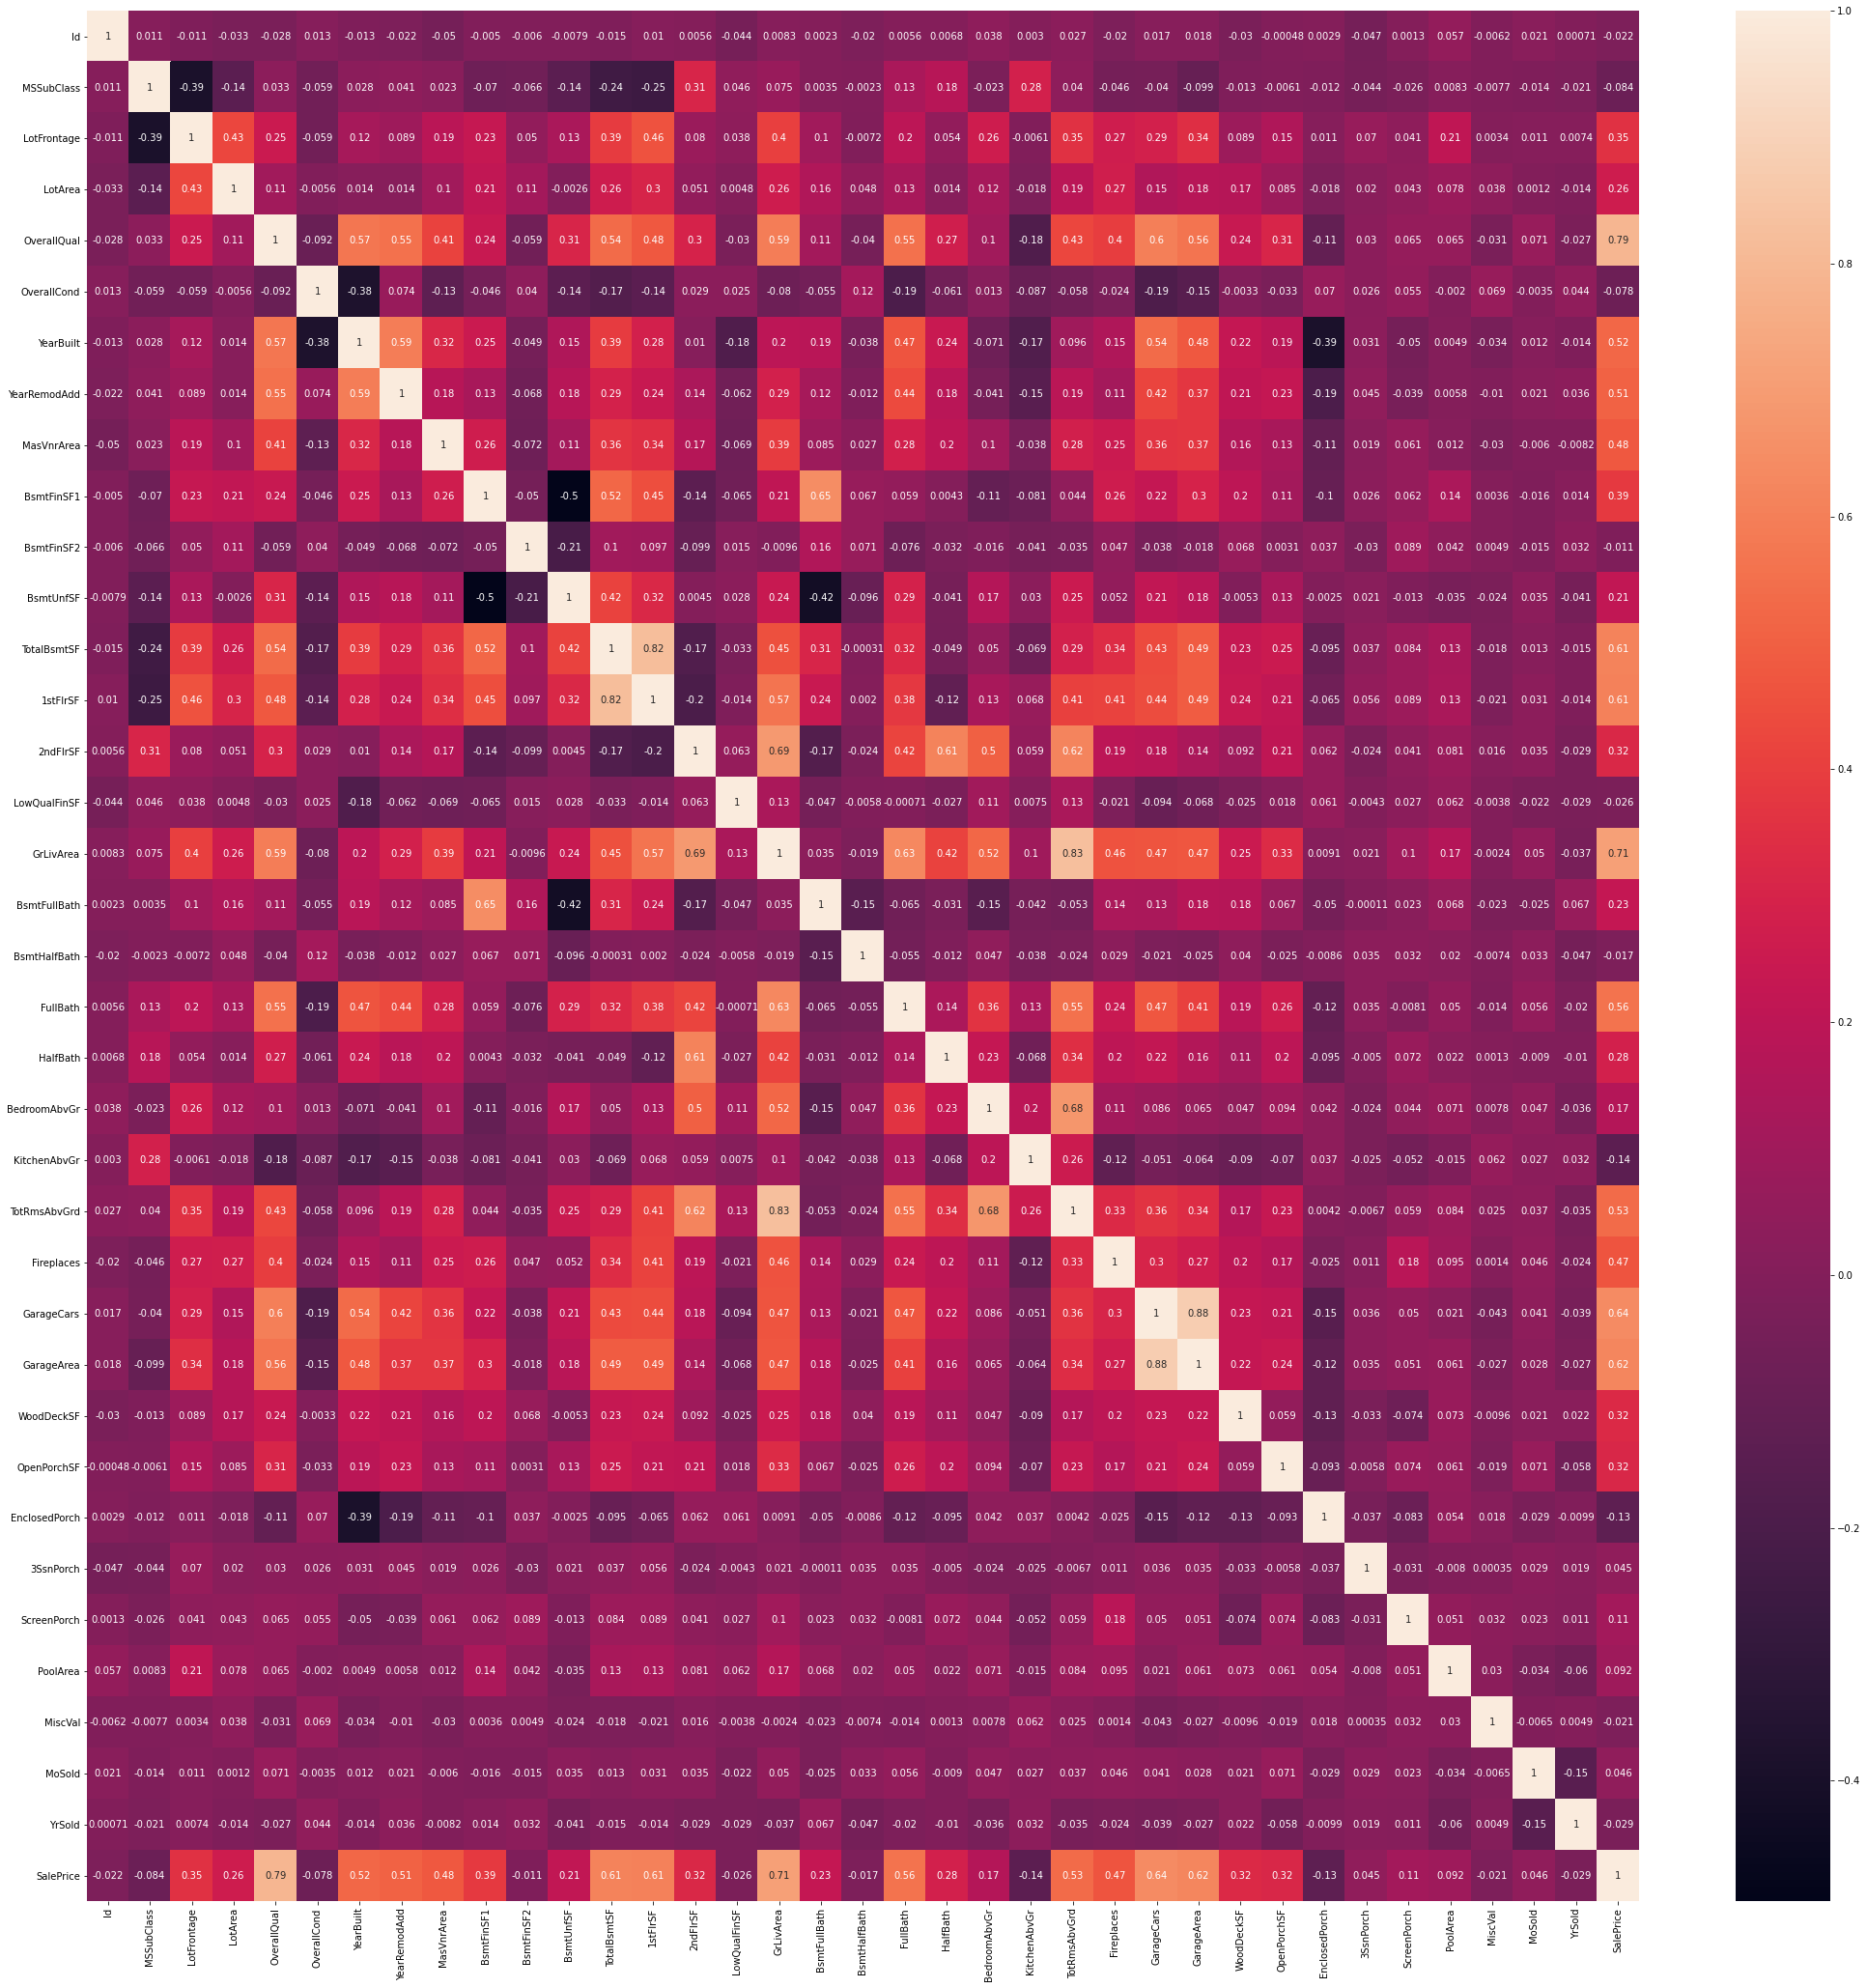

In [3]:
fig, ax = plt.subplots(figsize=(36, 36))
df_corr = X.corr()

sns.heatmap(df_corr,annot=True)

In [4]:
class cleaner(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):


        


        X.Electrical = X.Electrical.fillna('SBrkr')
        X.BsmtFinSF1 = X.BsmtFinSF1.fillna(0)
        X.BsmtFinSF2 = X.BsmtFinSF2.fillna(0)
        X.GarageCars = X.GarageCars.fillna(0)
        X.GarageArea = X.GarageArea.fillna(0)
        X["PoolQC"] = X["PoolQC"].fillna("NA")
        X.BsmtQual[(X.BsmtFinSF1 == 0)] = X.BsmtQual[(X.BsmtFinSF1 == 0)].fillna('NA')
        X.BsmtCond[(X.BsmtFinSF1 == 0)] = X.BsmtCond[(X.BsmtFinSF1 == 0)].fillna('NA')
        X.BsmtCond = X.BsmtCond.fillna('TA')
        X.BsmtExposure[(X.BsmtFinSF1 == 0)] = X.BsmtExposure[(X.BsmtFinSF1 == 0)].fillna('NA')
        X.BsmtFinType1[(X.BsmtFinSF1 == 0)] = X.BsmtFinType1[(X.BsmtFinSF1 == 0)].fillna('NA')
        X.BsmtFinType2[(X.BsmtFinSF2 == 0)] = X.BsmtFinType2[(X.BsmtFinSF2 == 0)].fillna('NA')
        X.BsmtFinType2 = X.BsmtFinType2.fillna('Unf')
        X["MiscFeature"] = X["MiscFeature"].fillna("NA")
        X["Alley"] = X["Alley"].fillna("NA")
        X["Fence"] = X["Fence"].fillna("NA")
        X["FireplaceQu"] = X["FireplaceQu"].fillna("NA")
        X['MSSubClass'] = X['MSSubClass'].fillna("NA")
        for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
            X[col] = X[col].fillna('NA')

        #Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
        X["LotFrontage"] = X.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))

        X.MasVnrArea = X.MasVnrArea.fillna(0)
        X.MasVnrType = X.MasVnrType.fillna('None')
        X.KitchenQual = X.KitchenQual.fillna('TA')
        X.Functional = X.Functional.fillna('Typ')
        X.BsmtUnfSF = X.BsmtUnfSF.fillna(0)
        X.TotalBsmtSF = X.TotalBsmtSF.fillna(0)
        X.BsmtFullBath = X.BsmtFullBath.fillna(0)
        X.BsmtHalfBath = X.BsmtHalfBath.fillna(0)

        #feature engineering for the Neighborhood
        X.loc[(X.Neighborhood == 'NridgHt') | (X.Neighborhood == 'NoRidge'), ['GoodNBH']] = 1
        X.GoodNBH = X.GoodNBH.fillna(0)
        X = X.drop(['Neighborhood'], axis=1)

        #Drop Categoricals that cannot be one hotted, and also not ordinally encoded
        X['Exterior1st'] = X['Exterior1st'].fillna(X['Exterior1st'].mode()[0])
        X['Exterior2nd'] = X['Exterior2nd'].fillna(X['Exterior2nd'].mode()[0])

        X['MSZoning'] = X['MSZoning'].fillna(X['MSZoning'].mode()[0])
        X['SaleType'] = X['SaleType'].fillna(X['SaleType'].mode()[0])

        #Convert data thats really categorical
        X['MSSubClass'] = X['MSSubClass'].apply(str) 
        X['OverallQual'] = X['OverallQual'].astype(str)  
        X['OverallCond'] = X['OverallCond'].astype(str)    
        X['YrSold'] = X['YrSold'].astype(str)
        X['MoSold'] = X['MoSold'].astype(str)
        X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
        
        return X

class unskew(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        skewed_features = ['MiscVal','PoolArea','LotArea','3SsnPorch','LowQualFinSF', 'KitchenAbvGr','BsmtFinSF2','BsmtHalfBath','ScreenPorch','EnclosedPorch','MasVnrArea','OpenPorchSF','WoodDeckSF' ,'LotFrontage','BsmtUnfSF','1stFlrSF' ,'GrLivArea','2ndFlrSF']
        lam = 0.15
        for feat in skewed_features:
            X[feat] = boxcox1p(X[feat], lam)
        
        return X


In [5]:
class df_Ord(BaseEstimator, TransformerMixin):
    def __init__(self,cols = [] ,cats = []):
        self.ord = None
        self.cols = cols
        self.cats = cats
      

    def fit(self, X, y=None):
        if self.cats == []:
            self.ord = OrdinalEncoder(categories="auto")
        else:
            self.ord = OrdinalEncoder(categories=[self.cats])
            
        for col in self.cols:

            self.ord.fit(X[[col]])        
        return self

    def transform(self, X):
        # X has to be a dataframe
        Xord = X.copy()
        for col in self.cols:
            Xord[col] = self.ord.transform(X[[col]])                
        Xorded = pd.DataFrame(Xord, index=X.index, columns=X.columns)
        return Xorded

class df_OH(BaseEstimator, TransformerMixin):
    def __init__(self,cols = []):
        self.OH = None
        self.cols = cols

    def fit(self, X, y=None):
        
        self.OH = OneHotEncoder(handle_unknown='ignore', sparse=False)


        self.OH.fit(X[self.cols])        
        return self

    def transform(self, X):

        XOHedcols = pd.DataFrame(self.OH.transform(X[self.cols]))  
        XOHedcols.index = X.index
        numX = X.drop(self.cols, axis=1)
        XOHed = pd.concat([numX,XOHedcols], axis=1)
        return XOHed    
    
    



 mu = 180921.20 and sigma = 79415.29



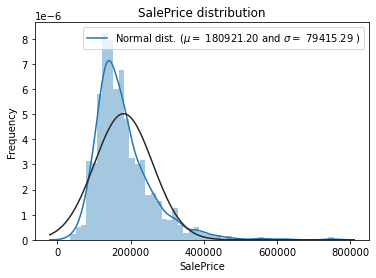

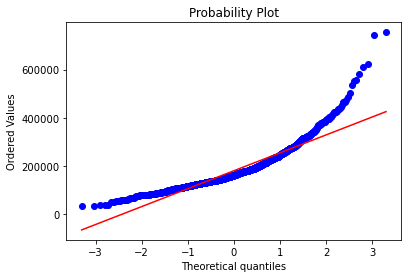


 mu = 12.02 and sigma = 0.40



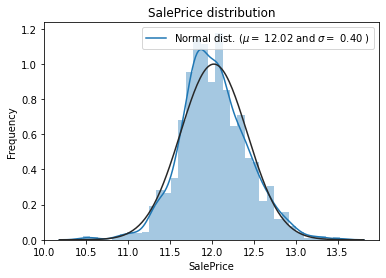

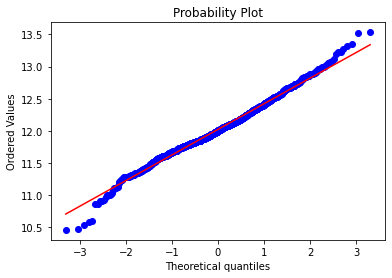

In [6]:
    



#correcting right Skew of data

sns.distplot(X['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(X['SalePrice'], plot=plt)
plt.show()


#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
X["SalePrice"] = np.log1p(X["SalePrice"])

#Check the new distribution 
sns.distplot(X['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(X['SalePrice'], plot=plt)
plt.show()

#drop outlier
X = X.drop(X[(X['GrLivArea']>4000) & (X['SalePrice']<300000)].index)


X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)    
    


In [7]:

regressors = [
    RandomForestRegressor(n_estimators=800, random_state=0)
    ,XGBRegressor(n_estimators=800, learning_rate=0.03)
    ,XGBRegressor(learning_rate=0.05, max_depth=3,n_estimators=200)
    ,Lasso(alpha =0.0003, random_state=0)
    ,ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
    ,lgb.LGBMRegressor(objective='regression',num_leaves=7,
                              learning_rate=0.02, n_estimators=800,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
    ]




for regressor in regressors:
    pipe = Pipeline([
                         ('clean', cleaner())
                         ,('ord',df_Ord(cols=['ExterQual','ExterCond','HeatingQC','KitchenQual'], cats=['Po','Fa','TA','Gd','Ex']))
                         ,('ord2',df_Ord(cols=['BsmtQual','BsmtCond','FireplaceQu','GarageQual','GarageCond'], cats=['NA','Po','Fa','TA','Gd','Ex']))
                         ,('ord3',df_Ord(cols=['PoolQC'], cats=['NA','Fa','TA','Gd','Ex']))
                         ,('ord4',df_Ord(cols=['MiscFeature'], cats=['NA','Othr','Shed','Gar2','Elev','TenC']))
                         ,('ord5',df_Ord(cols=['Fence'], cats=['NA','MnWw','GdWo','MnPrv','GdPrv']))
                         ,('ord6',df_Ord(cols=['Alley'], cats=['NA','Grvl','Pave']))
                         ,('ord7',df_Ord(cols=['BsmtExposure'], cats=['NA','No','Mn','Av','Gd']))
                         ,('ord8',df_Ord(cols=['BsmtFinType1','BsmtFinType2'], cats=['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'])) 
                         ,('ord9',df_Ord(cols=['CentralAir'], cats=['N','Y'])) 
                         ,('ord10',df_Ord(cols=['Functional'], cats=['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']))
                         ,('ord11',df_Ord(cols=['MSSubClass'], cats=['20','30','40','45','50','60','70','75','80','85','90','120','150','160','180','190']))
                         ,('ord12',df_Ord(cols=['YrSold']))
                         ,('ord13',df_Ord(cols=['MoSold']))
                         ,('ord14',df_Ord(cols=['OverallCond']))
                         ,('ord15',df_Ord(cols=['OverallQual']))
                         ,('ord16',df_Ord(cols=['GarageType']))
                         ,('ord17',df_Ord(cols=['GarageFinish']))
                         ,('ord18',df_Ord(cols=['Exterior1st']))
                         ,('ord19',df_Ord(cols=['Exterior2nd']))                          
                         ,('oh1',df_OH(cols=['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'PavedDrive', 'SaleType', 'SaleCondition']))
                         ,('unskew', unskew())
                         #,('scaler', RobustScaler())
                         ,('model', regressor)
                         ])
    pipe.fit(X_train, y_train)   
    print(regressor)
    
    preds = pipe.predict(X_valid)
    print("model score: %.3f" % mean_absolute_error(np.expm1(y_valid), np.expm1(preds)))
    




RandomForestRegressor(n_estimators=800, random_state=0)
model score: 16078.040
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=800, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
model score: 15519.791
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_const

In [8]:
df = pd.DataFrame(columns=['Id','SalePrice'])
df['Id'] = X_valid.Id
df['SalePrice'] = np.expm1(preds)
df[['Id','SalePrice']].to_csv('submission1.csv', index=False)

In [40]:
#Special to solve the early stopper limitation on pipelines
pipeXGB = Pipeline([
                         ('clean', cleaner())
                         ,('ord',df_Ord(cols=['ExterQual','ExterCond','HeatingQC','KitchenQual'], cats=['Po','Fa','TA','Gd','Ex']))
                         ,('ord2',df_Ord(cols=['BsmtQual','BsmtCond','FireplaceQu','GarageQual','GarageCond'], cats=['NA','Po','Fa','TA','Gd','Ex']))
                         ,('ord3',df_Ord(cols=['PoolQC'], cats=['NA','Fa','TA','Gd','Ex']))
                         ,('ord4',df_Ord(cols=['MiscFeature'], cats=['NA','Othr','Shed','Gar2','Elev','TenC']))
                         ,('ord5',df_Ord(cols=['Fence'], cats=['NA','MnWw','GdWo','MnPrv','GdPrv']))
                         ,('ord6',df_Ord(cols=['Alley'], cats=['NA','Grvl','Pave']))
                         ,('ord7',df_Ord(cols=['BsmtExposure'], cats=['NA','No','Mn','Av','Gd']))
                         ,('ord8',df_Ord(cols=['BsmtFinType1','BsmtFinType2'], cats=['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'])) 
                         ,('ord9',df_Ord(cols=['CentralAir'], cats=['N','Y'])) 
                         ,('ord10',df_Ord(cols=['Functional'], cats=['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']))
                         ,('ord11',df_Ord(cols=['MSSubClass'], cats=['20','30','40','45','50','60','70','75','80','85','90','120','150','160','180','190']))
                         ,('ord12',df_Ord(cols=['YrSold']))
                         ,('ord13',df_Ord(cols=['MoSold']))
                         ,('ord14',df_Ord(cols=['OverallCond']))
                         ,('ord15',df_Ord(cols=['OverallQual']))
                         ,('ord16',df_Ord(cols=['GarageType']))
                         ,('ord17',df_Ord(cols=['GarageFinish']))
                         ,('ord18',df_Ord(cols=['Exterior1st']))
                         ,('ord19',df_Ord(cols=['Exterior2nd']))                          
                         ,('oh1',df_OH(cols=['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'PavedDrive', 'SaleType', 'SaleCondition']))
                         ,('unskew', unskew())
                         ])
    
# Transform the data
X_train = pipeXGB.fit_transform(X_train)
X_valid = pipeXGB.transform(X_valid)



AttributeError: 'DataFrame' object has no attribute 'Electrical'

In [25]:
#####LASSO
from sklearn.model_selection import RepeatedKFold


lass = Lasso(alpha =0.0003, random_state=0,max_iter=15000)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 0.1, 0.0001)

search = GridSearchCV(lass, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1,verbose=2)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)


Fitting 30 folds for each of 1000 candidates, totalling 30000 fits
MAE: -0.085
Config: {'alpha': 0.0006000000000000001}


NameError: name 'best_params_' is not defined

In [29]:
lass2 = Lasso(alpha =0.0006, random_state=0,max_iter=1000)
lass2.fit(X_train, y_train)
lasspred = lass2.predict(X_valid)   

print("Pimped Lasso: " + str(mean_absolute_error(np.expm1(y_valid), np.expm1(lasspred))))

Pimped Lasso: 14222.327904298274


In [31]:
############RIDGE

#https://machinelearningmastery.com/ridge-regression-with-python/
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

ridge = Ridge(alpha =0.0003, random_state=0)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(17, 18, 0.001)

search = GridSearchCV(ridge, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1,verbose=2)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)




Fitting 30 folds for each of 1000 candidates, totalling 30000 fits
MAE: -0.086
Config: {'alpha': 17.0}


In [32]:
ridge2 = Ridge(alpha =17, random_state=0)

ridge2.fit(X_train, y_train)
ridgepreds = ridge2.predict(X_valid)   

print("Pimped Ridge: " + str(mean_absolute_error(np.expm1(y_valid), np.expm1(ridgepreds))))

Pimped Ridge: 14470.113424246276


In [106]:
######LGBM Bayes

import lightgbm as lgb
from bayes_opt import BayesianOptimization
def search_best_param(X,y,cat_features):
    
    trainXY = lgb.Dataset(data=X, label=y,categorical_feature = cat_features,free_raw_data=False)
    # define the lightGBM cross validation
    def lightGBM_CV(
        num_leaves, 
        max_bin,
        bagging_freq, 
        #lambda_l1 
        #lambda_l2
        ):
    
        params = {'boosting_type': 'gbdt', 'objective': 'regression', 'metric':'rmse', 'verbose': -1,
                  'early_stopping_round':500
                 ,'n_estimators': 800
                 ,'learning_rate': 0.02
                 #,'max_bin': 55
                 ,'bagging_fraction' : 0.8
                 #,'bagging_freq' : 5
                 ,'feature_fraction' : 0.2319
                 ,'feature_fraction_seed':9
                 ,'bagging_seed':9
                 ,'min_data_in_leaf' : 6
                 ,'min_sum_hessian_in_leaf' : 11
                 ,'num_leaves' : 7
                 ,'max_depth':-1
                 
                 
                 }
        
        #params['max_depth'] = int(round(max_depth))
        params["num_leaves"] = int(round(num_leaves))
        params["max_bin"] = int(round(max_bin))
        params['bagging_freq'] = int(round(bagging_freq))
        #params['subsample'] = subsample
        #params['colsample_bytree'] = colsample_bytree
        #params['lambda_l1'] = max(lambda_l1, 0)
        #params['lambda_l2'] = max(lambda_l2, 0)
        #params['min_child_weight'] = min_child_weight
    
        score = lgb.cv(params, trainXY, nfold=5, seed=1, stratified=False, verbose_eval =False, metrics=['rmse'])

        return -np.min(score['rmse-mean']) # return negative rmse to minimize rmse 

    # use bayesian optimization to search for the best hyper-parameter combination
    lightGBM_Bo = BayesianOptimization(lightGBM_CV, 
                                       {
                                         # 'max_depth': (3, 30),
                                          'num_leaves': (3, 20),
                                         
                                
                                          'max_bin': (20,80),
                                          'bagging_freq' :(2, 20),
                                         #'lambda_l1': (0, 10)
                                          #'lambda_l2': (0, 10),
                                         # 'min_child_weight': (2, 100) 
                                      },
                                       random_state = 1,
                                       verbose = 1
                                      )
    np.random.seed(1)
    
    lightGBM_Bo.maximize(init_points=5, n_iter=15) 
    
    params_set = lightGBM_Bo.max['params']
    
    # get the params of the maximum target     
    max_target = -np.inf
    for i in lightGBM_Bo.res: # loop thru all the residuals 
        if i['target'] > max_target:
            params_set = i['params']
            max_target = i['target']
    
    params_set.update({'verbose': -1})
    params_set.update({'metric': 'rmse'})
    params_set.update({'boosting_type': 'gbdt'})
    params_set.update({'objective': 'regression'})

    
    params_set['num_leaves'] = int(round(params_set['num_leaves']))
    params_set['max_bin'] = int(round(params_set['max_bin']))    
    params_set['bagging_freq'] = int(round(params_set['bagging_freq']))
    #params_set['lambda_l2'] = int(round(params_set['lambda_l2']))

    params_set['seed'] = 1 #set seed
    
    return params_set
cat_features = X_train.select_dtypes(['object']).columns.to_list()
best_params = search_best_param(X_train,y_train,cat_features)

for key, value in best_params.items():
    print(key, ' : ', value)

train_data=lgb.Dataset(X_train,label=y_train, categorical_feature = cat_features,free_raw_data=False)
valid_data=lgb.Dataset(X_valid,label=y_valid, categorical_feature = cat_features,free_raw_data=False)

lgbm_best = lgb.train(best_params,
                 train_data,
                 num_boost_round = 2000,
                 valid_sets = valid_data,
                 early_stopping_rounds = 500,
                 verbose_eval = 100
                 )

#df = pd.DataFrame(columns=['Id','SalePrice'])
#df['Id'] = X_test.Id
#df['SalePrice'] = np.expm1(lgbm_best.predict(X_test))
#df[['Id','SalePrice']].to_csv('submission1.csv', index=False)

|   iter    |  target   | baggin... |  max_bin  | num_le... |
-------------------------------------------------------------
|  2        | -0.1236   |  7.442    |  28.81    |  4.57     |
|  3        | -0.1225   |  5.353    |  40.73    |  9.745    |
|  6        | -0.1225   |  4.752    |  41.63    |  9.14     |
bagging_freq  :  5
max_bin  :  42
num_leaves  :  9
verbose  :  -1
metric  :  rmse
boosting_type  :  gbdt
objective  :  regression
seed  :  1
Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 0.110677
[200]	valid_0's rmse: 0.111957
[300]	valid_0's rmse: 0.112354
[400]	valid_0's rmse: 0.113005
[500]	valid_0's rmse: 0.114274
Early stopping, best iteration is:
[93]	valid_0's rmse: 0.110545


In [107]:
lgbmpreds = lgbm_best.predict(X_valid)   
print("Pimped lgbm: " + str(mean_absolute_error(np.expm1(y_valid), np.expm1(lgbmpreds))))

Pimped lgbm: 14477.026144585114


In [35]:
xgbr = XGBRegressor(colsample_bytree=0.7
                     , gamma=0.06
                     , min_child_weight=8
                     , subsample=0.6
                     , learning_rate=0.06
                     , max_depth=5
                     , num_leaves=20
                     , n_estimators=400)

params = {
              
             # 'num_leaves': list(range(20, 100,5)),
             # 'n_estimators': list(range(50, 1000,50)),

          }



xgbrcv = GridSearchCV(model, params, cv = 5, scoring='neg_mean_absolute_error',verbose=2)
xgbrcv.fit(X_train, y_train)

print(xgbrcv.best_params_)
print(xgbrcv.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
{}
-0.08565637910837777


In [38]:

xgbrpreds = xgbrcv.predict(X_valid)   
print("Pimped XGBM: " + str(mean_absolute_error(np.expm1(y_valid), np.expm1(xgbrpreds))))

Pimped XGBM: 14461.034995719177


In [22]:
df = pd.DataFrame(columns=['Id','SalePrice'])
df['Id'] = X_test.Id
df['SalePrice'] = np.expm1(preds)
df[['Id','SalePrice']].to_csv('submission1.csv', index=False)

In [141]:
lgbgamble = lgb.LGBMRegressor(objective='regression',num_leaves=7,
                              learning_rate=0.02, n_estimators=800,
                              max_bin = 48, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 10)


lgbgamble.fit(X_train,y_train)
lgbgamblepreds = lgbgamble.predict(X_test)
print("model score: %.3f" % mean_absolute_error(np.expm1(y_valid), np.expm1(lgbgamblepreds)))
    
df = pd.DataFrame(columns=['Id','SalePrice'])
df['Id'] = X_test.Id
df['SalePrice'] = np.expm1(lgbgamblepreds)
df[['Id','SalePrice']].to_csv('submission1.csv', index=False)


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
